### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework. 
### Radmehr Ghassabtabarshiadeh

Part A

A/B testing to determine whether SHVR or ZIC traders perform better using BSE market sessions simulation. The null hypothesis tested is that there is no signifacnt difference between the two traders and the alternative hypothesis of there being a signifacnt difference between the two traders, with the significance value (alpha) set to 0.05. A market session will run with the specification mentioned on the brief with start time and end time are set to 0 and 600 respectively. After the simulation are complete, two data frames are created, one with everything the "dump_avgbals" creates and another only taking in the accumilated average profit of each trader, this process is repeated for n number of sessions. To test the hypothesis, first normality of the data ismeasured and either a parametric or a non-parametric test is performed. Some helper functions are below to help do what was described. The functions "make_df" and "collect_avg_profit" are helper functions for "run_market_sim" which create a dataframe and grab the average profit for the two traders after each n session. The collected averages, are passed in to Shapiro-Wilk test to understand their distribution. t-test will be utilised as the parametric test and Mann-Whitney-U as the non-parametric test.

In [16]:
from helper import *
from scipy import stats

In [6]:
n500mean_shvr, n500mean_zic = run_market_sim(trial_id="n500", no_sessions=500, R=50, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=60*10, path='n500_avg_balance.csv')
n50mean_shvr, n50mean_zic = run_market_sim(trial_id="n50", no_sessions=50, R=50, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=60*10, path='n50_avg_balance.csv')

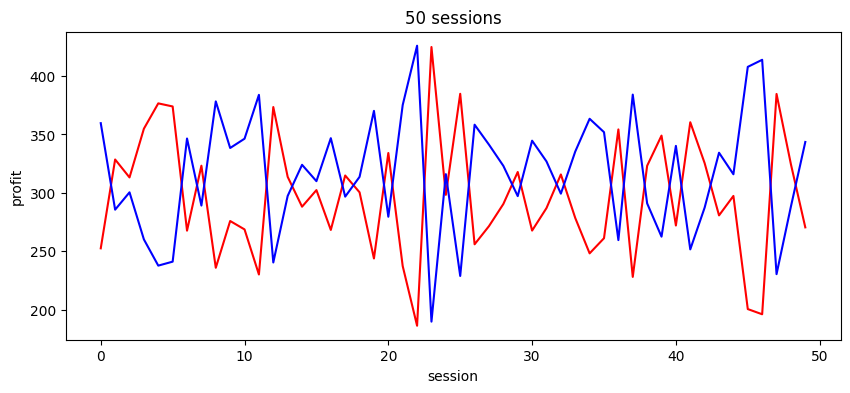

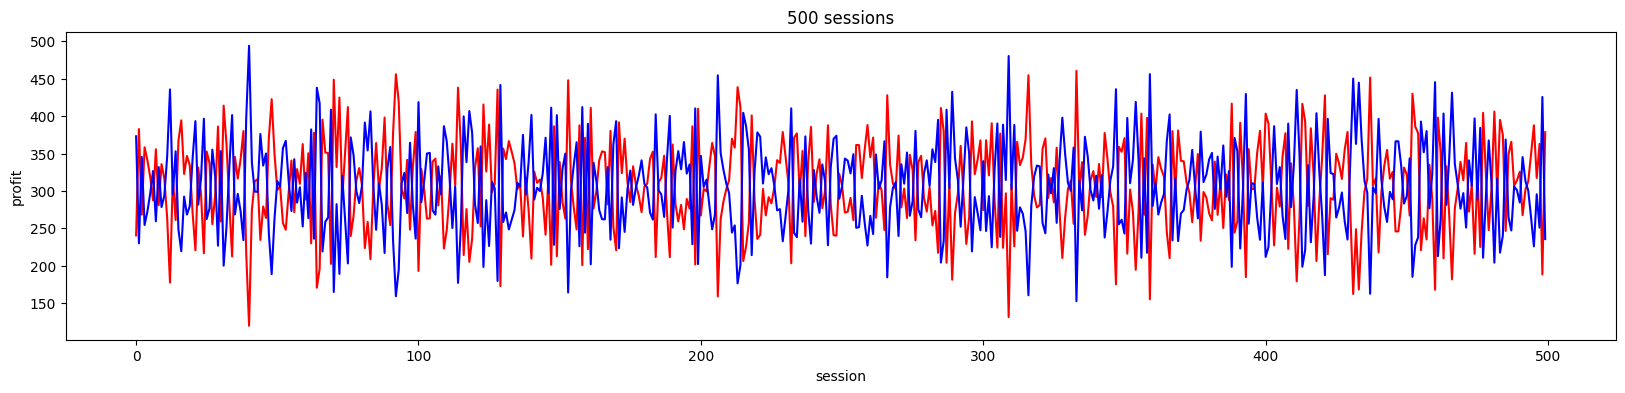

In [7]:
plot_performance(n50mean_zic, n500mean_zic, n50mean_shvr, n500mean_shvr)

The plots above showcase what was the average profit a trader made at the end of a session, zic traders being red and shvr traders being blue. It is observed that the profitablity is shared roughly equally between the two traders. So the expected results from the statistical test would be to conclude that we do not have sufficient evidence to reject the null hypothesis. That mean, there is no significant difference between the two traders when it comes to average profit in the market.

In [8]:
_, pvalue50_shvr = stats.shapiro(n500mean_shvr)
_, pvalue500_shvr = stats.shapiro(n50mean_shvr)
_, pvalue500_zic = stats.shapiro(n500mean_zic)
_, pvalue50_zic = stats.shapiro(n50mean_zic)
print(pvalue50_shvr, pvalue500_zic, pvalue50_zic, pvalue500_shvr)

0.39218419790267944 0.4235941171646118 0.8988999724388123 0.9075339436531067


Shapiro-Wilk test is utilised to understand the distribution of each data, if they are following a normal distribution a parametric test is used, otherwise a non-parametric test is utilised. As the output demonstrates, all datasets are following a normal distribution therefore, no further normalisation is required and a t-test can be used. This is due to the p value of each sample being higher than the threshold of 0.05.

In [9]:
_, p_val50 = stats.ttest_ind(n50mean_zic, n50mean_shvr)
print(p_val50, 'p val for 50 sessions')
_, p_val500 = stats.ttest_ind(n500mean_zic, n500mean_shvr)
print(p_val500, 'p val for 500 sessions')

0.058246140067733605 p val for 50 sessions
0.7109291594744184 p val for 500 sessions


In the simulated market sessions, the p value for both number of sessions n is above the threshold of 0.05, meaning we do not have sufficient evidence to reject the null hypothesis. In other words, we can conclude that there is no significant difference between the two trader's performance when comparing the average profit per session.

PART B

For this part, the ratio of the market agents are manipulated to the brief's specification. Code cell below, modifies the previously used code to accomedate these changes by collecting and returning the resaults in an two dimensional array. Within each resault, there are two data sets, the first being mean profit of shvr while the second being zic traders. For each pair of data, 9 in this case, they will be tested to see whether they are normaly distributed using Shapiro-Wilk and then appropriate hypothesis testing. Another thing to consider is the variance of the data, since there are different number of traders in the market, the variance difference will be high. Welch's t-test is a form of t-test when variance variable is set to false and is utilised here.

In [10]:
R = [10, 20, 30, 40, 50, 60, 70, 80, 90]

res50 = R_market_run(R, 50, 20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60) #9 arr corresponding to each ratio, res[n][0]=shvr, [n][1]=zic each 50 long                                                                                                             #res[n][0] = shvr, res[n][1] = zic
res500 = R_market_run(R, 500, 20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60) #same as above but 500 long

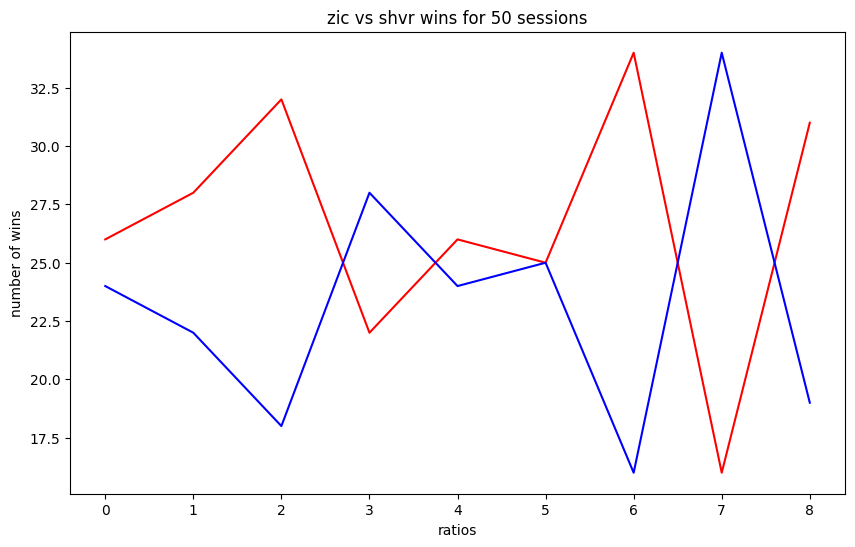

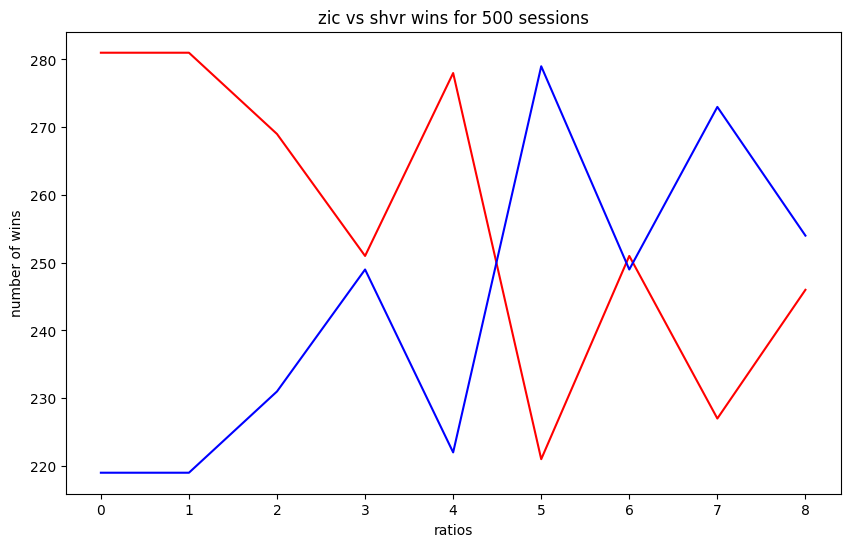

In [11]:
plot_wins(res50)
plot_wins(res500)

To visualise the results of the market sessions, the number of "wins" a trader has over the other is plotted against all ratios from 1 to 9m with red being shvr and blue zic. The "number of wins" means the number of time the average profit of a the trader was higher than the other trader during the n sessions with a given ratio, ie at 0 for every 1 shvr trader there are 9 zic traders. when n=50, there is not enough to separate the two traders as they seem fairly similar. However as we increase the number of sessions the dominant trader type becomes better as there is simply more of them. All left to do is to test the significance of this data collected to draw a conclusion. To account for this high variance, when using a t-test, "equal_var" variable is set to False.

In [12]:
p_vals_50 = collect_pvals_norm(res50)
p_vals_500 = collect_pvals_norm(res500)

p_res50 = A_B_test(p_vals_50, res50)
p_res500 = A_B_test(p_vals_500, res500)

n=50 ratio: 1 to 9 is NORMAL used parametric test, p val is: 0.07844383958149502
n=50 ratio: 2 to 8 is NORMAL used parametric test, p val is: 0.31556027715762314
n=50 ratio: 3 to 7 is NORMAL used parametric test, p val is: 3.1014414316708306e-05
n=50 ratio: 4 to 6 is NORMAL used parametric test, p val is: 0.6813178370510911
n=50 ratio: 5 to 5 is NORMAL used parametric test, p val is: 0.696991589493192
n=50 ratio: 6 to 4 is NORMAL used parametric test, p val is: 0.30910795354134146
n=50 ratio: 7 to 3 is NOT normal used NON-parametric test, p val is: 0.029630103592925876
n=50 ratio: 8 to 2 is NORMAL used parametric test, p val is: 0.0874493251246022
n=50 ratio: 9 to 1 is NORMAL used parametric test, p val is: 0.18885897332094248
n=500 ratio: 1 to 9 is NOT normal used NON-parametric test, p val is: 0.0002970346971539202
n=500 ratio: 2 to 8 is NORMAL used parametric test, p val is: 6.427635778038207e-09
n=500 ratio: 3 to 7 is NORMAL used parametric test, p val is: 0.00039713797623106863
n=

When n=50, there is simply not enough data to conclude any evidence from the p values generated as it can vary dramatically with each run. In the simulation above, there is no logic or pattern to the output as mostly it suggest no significance except for two instances of 3 to 7 and 7 to 3. However as the number of sessions are increased, there is a clear picture of what ever trader type dominating the market does better than the other. the test resaults suggest as there is a bigger gap in the ratios, the more statistical significance that one trader is better than the other. This was also observed when the wins diagrams was plotted.

PART C

In [17]:
t = [25, 25, 25, 25]
t1 = [40, 20, 20, 20]
t2 = [10, 30, 30, 30]
t3 = [70, 10, 10, 10]

#res(shvr, gvwy, zic, zip) 0 perm 1, 1 perm2, ... if equal ratios len(res) == 1 else, 4
r_1_50 = run_market_sim_four("same50", no_sessions=50, t=t, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r_2_50 = run_market_sim_four("forty50", no_sessions=50, t=t1, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r_3_50 = run_market_sim_four("ten50", no_sessions=50, t=t2, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r_4_50 = run_market_sim_four("seventy50", no_sessions=50, t=t3, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

r_1_500 = run_market_sim_four("same500", no_sessions=500, t=t, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r_2_500 = run_market_sim_four("forty500", no_sessions=500, t=t1, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r_3_500 = run_market_sim_four("ten500", no_sessions=500, t=t2, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r_4_500 = run_market_sim_four("seventy500", no_sessions=500, t=t3, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [ ]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

In [ ]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "CW-IEFT-template.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 832. Limit is 2000 words.
